# Dataset window preprocess

##1. Upload data to Colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = '/content/gdrive/MyDrive/Colab Notebooks ESTA CUENTA/Euromillones/'

## 2. Import libraries


In [ ]:
#Cargar librerias necesarias
from matplotlib import pyplot as plt, patches
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate, BatchNormalization, ReLU, GRU, Reshape, Attention
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import time
from datetime import datetime

import os as os

from google.colab import drive
from sklearn.model_selection import train_test_split

!pip install plot_keras_history
from plot_keras_history import plot_history

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9455 sha256=5bad3682036749676dcaf15b68944a4e466d6df046712f53291378922da9d654
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.51-py3-none-any.whl size=321865 sha256=1a98f841409d52ca60211d33a839b62d2bbe264aad26908ce5cae07296ab850d
  Stored in directory: /root/.cache/pip/wheels/30/9f/f5/37d037c39ac8b305590d5956f7021c6ca94b63c68be24f6841
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5631 sha256=1acf701a3303f102e46e2faa82bae58b1062c580b229fcc481c2a9dca81d98ec
  Stored in directo

## 3. Load and manage data



In [ ]:
train = pd.read_csv(data_path+'euromillions_train.csv',
                    #names=['date', 'b1', 'b2', 'b3', 'b4', 'b5', 'e1', 'e2'],
                    delimiter=';')

train.head()

,date,b1,b2,b3,b4,b5,e1,e2
0,13/02/2004,32,16,29,41,36,9,7
1,20/02/2004,13,50,47,7,39,2,5
2,27/02/2004,37,19,18,14,31,5,4
3,05/03/2004,39,37,4,7,33,5,1
4,12/03/2004,44,47,15,28,24,4,5


In [ ]:
train.dtypes

date    object
b1       int64
b2       int64
b3       int64
b4       int64
b5       int64
e1       int64
e2       int64
dtype: object

In [ ]:
test = pd.read_csv(data_path+'euromillions_test.csv',
                    #names=['date', 'b1', 'b2', 'b3', 'b4', 'b5', 'e1', 'e2'],
                    delimiter=';')

test.head()

,date,b1,b2,b3,b4,b5,e1,e2
0,01/01/2019,11,25,8,28,1,4,6
1,04/01/2019,19,7,11,37,27,10,6
2,08/01/2019,19,32,31,3,22,2,11
3,11/01/2019,19,48,31,39,1,6,1
4,15/01/2019,33,22,35,25,29,3,6


In [ ]:
test.iloc[-1,:]

date    28/11/2023
b1              12
b2              16
b3              27
b4              33
b5              44
e1               7
e2               8
Name: 511, dtype: object

In [ ]:
def normalize_data(df):
  df_n = df.copy()
  df_n.iloc[:,1:6] = (df_n.iloc[:,1:6]-1)/(50-1)
  df_n.iloc[:,6:] = (df_n.iloc[:,6:]-1)/(12-1)
  #df_n = np.reshape(df_n.values, (df_n.shape[0], df_n.shape[1], 1))
  return df_n

In [ ]:
train_norm = normalize_data(train)
test_norm = normalize_data(test)

In [ ]:
train_norm.head()

,date,b1,b2,b3,b4,b5,e1,e2
0,13/02/2004,0.632653,0.306122,0.571429,0.816327,0.714286,0.727273,0.545455
1,20/02/2004,0.244898,1.000000,0.938776,0.122449,0.775510,0.090909,0.363636
2,27/02/2004,0.734694,0.367347,0.346939,0.265306,0.612245,0.363636,0.272727
3,05/03/2004,0.775510,0.734694,0.061224,0.122449,0.653061,0.363636,0.000000
4,12/03/2004,0.877551,0.938776,0.285714,0.551020,0.469388,0.272727,0.363636


In [ ]:
test_norm.iloc[-1, :]

date    28/11/2023
b1         0.22449
b2        0.306122
b3        0.530612
b4        0.653061
b5        0.877551
e1        0.545455
e2        0.636364
Name: 511, dtype: object

In [ ]:
train_norm = train_norm.drop('date', axis=1)
test_norm = test_norm.drop('date', axis=1)

In [ ]:
rows = train_norm.values.shape[0]
print(rows)
W = 5
features = train_norm.values.shape[1]
features=7
print(features)

1176
7


In [ ]:
W = W # size of the window (previous draws)
h = 1 # number of prediction draws forward

In [ ]:
X_train = np.empty([rows-W, W, features], dtype=float)
y_train = np.empty([rows-W, features], dtype=float)

for i in range(0, rows-W):
  X_train[i] = train_norm.iloc[i:i+W, 0:features]
  y_train[i] = train_norm.iloc[i+W:i+W+1, 0:features]

In [ ]:
X_train, X_val = train_test_split(X_train, test_size=0.2, shuffle=False)
y_train, y_val = train_test_split(y_train, test_size=0.2, shuffle=False)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(936, 5, 7)
(936, 7)
(235, 5, 7)
(235, 7)


In [ ]:
X_test = np.empty([test_norm.values.shape[0]-W, W, features], dtype=float)
y_test = np.empty([test_norm.values.shape[0]-W, features], dtype=float)

for i in range(0, test.values.shape[0]-W):
  X_test[i] = test_norm.iloc[i:i+W, 0:features]
  y_test[i] = test_norm.iloc[i+W:i+W+1, 0:features]

In [ ]:
print(X_test.shape)
print(y_test.shape)

(507, 5, 7)
(507, 7)


# 4. GRU ATENCIÓN

In [ ]:
def tf_symmetric_mean_absolute_percentage_error(labels, predictions):
    diff = tf.abs(labels - predictions)
    smape = tf.reduce_mean(diff / (tf.abs(labels) + tf.abs(predictions))) * 200
    return smape

def symmetric_mean_absolute_percentage_error(labels, predictions):
    diff = np.abs(labels - predictions)
    smape = np.mean(diff / (np.abs(labels) + np.abs(predictions))) * 200
    return smape

In [ ]:
def build_model():

  input = Input(name='series', shape=(W, features))

  latent_dim = 64

  #seed=100

  # RNN

  rnn_latent = GRU(latent_dim,
            name='gru',
            return_sequences=True)(input)

  #rnn_latent = Dense(latent_dim, activation='relu', name='rnn_dense', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(gru)
  #rnn_latent_reshape = Reshape((latent_dim, 1), name='rnn_latent_reshape')(gru)

   # Attention
  attention = Attention(name='attention')([rnn_latent, rnn_latent])
  latent_concat = tf.keras.layers.Concatenate(name='concat_attention')([rnn_latent, attention])

  flat = Flatten(name='flat_latent')(latent_concat)

  rnn_dense = Dense(128, activation='relu', name='rnn_dense')(flat)
  #rnn_dense_b = Dense(latent_dim*5, activation='relu', name='rnn_dense_b')(rnn_dense)


  # Concat
  #combined_concat = Concatenate(name='combined_concat')([cnn_latent, rnn_dense])

  #combined_dense = Dense(128, activation='relu', name='combined_dense', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(combined_concat)

  #combined_dense_2 = Dense(2*h_base, activation='relu', name='combined_dense_2', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(combined_dense)

  # Output
  output = Dense(features,activation='linear', name='final_output')(rnn_dense)

  #model = Model(inputs=[input, input_image], outputs=output, name='cnn_rnn')
  model = Model(inputs=input, outputs=output, name='cnn_rnn')

  model.compile(loss='mean_absolute_error',
                  optimizer=optimizers.Adam(1e-3),
                  metrics=[keras.metrics.MAPE, keras.metrics.MSE, keras.metrics.RootMeanSquaredError(), tf_symmetric_mean_absolute_percentage_error])
  return model

In [ ]:
# Directorio de trabajo y nombre del proyecto (dd-mm-aaaa)
workingDir = data_path+f'/test_0'
#os.mkdir(workingDir)

In [ ]:
# Definir el callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=10, min_lr=1e-7)

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "cnn_rnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 series (InputLayer)         [(None, 5, 7)]               0         []                            
                                                                                                  
 gru (GRU)                   (None, 5, 64)                14016     ['series[0][0]']              
                                                                                                  
 attention (Attention)       (None, 5, 64)                0         ['gru[0][0]',                 
                                                                     'gru[0][0]']                 
                                                                                                  
 concat_attention (Concaten  (None, 5, 128)               0         ['gru[0][0]',           

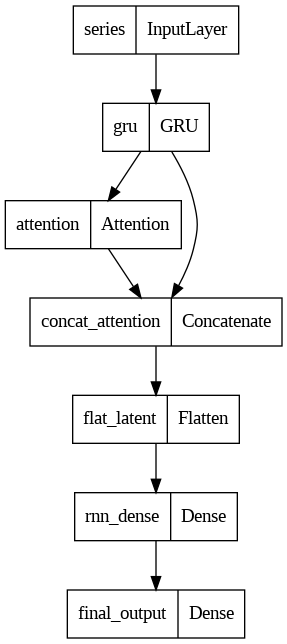

In [ ]:
keras.utils.plot_model(model, to_file=workingDir+f'/test_0.png')

In [ ]:
checkpoint_filepath = workingDir+f'test_0.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
# Definir callBacks para guardar metricas y las epochas y modelos en cada una de las epocas
logger = keras.callbacks.CSVLogger(workingDir+'/test_0.log')

batch_size=128

#Seguir entrenando el modelo hasta completar todas las epocas
train_tiempo_inicial = time.time()
history = model.fit(x=X_train, y=y_train,
                    epochs=500,
                    batch_size=batch_size,
                    verbose=1,
                    steps_per_epoch=len(X_train)/batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[logger,model_checkpoint_callback, reduce_lr, early_stopping])
train_tiempo_final = time.time()

Epoch 1/500
8/7 [================================] - ETA: 0s - loss: 0.3084 - mean_absolute_percentage_error: 15637837.0000 - mean_squared_error: 0.1423 - root_mean_squared_error: 0.3772 - tf_symmetric_mean_absolute_percentage_error: 80.6997

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 4s 155ms/step - loss: 0.3084 - mean_absolute_percentage_error: 15637837.0000 - mean_squared_error: 0.1423 - root_mean_squared_error: 0.3772 - tf_symmetric_mean_absolute_percentage_error: 80.6997 - val_loss: 0.2742 - val_mean_absolute_percentage_error: 18819342.0000 - val_mean_squared_error: 0.1027 - val_root_mean_squared_error: 0.3204 - val_tf_symmetric_mean_absolute_percentage_error: 61.8097 - lr: 0.0010
Epoch 2/500
7/7 [==============================] - 0s 24ms/step - loss: 0.2574 - mean_absolute_percentage_error: 18963962.0000 - mean_squared_error: 0.0914 - root_mean_squared_error: 0.3024 - tf_symmetric_mean_absolute_percentage_error: 62.8688 - val_loss: 0.2748 - val_mean_absolute_percentage_error: 13130113.0000 - val_mean_squared_error: 0.1062 - val_root_mean_squared_error: 0.3258 - val_tf_symmetric_mean_absolute_percentage_error: 65.2214 - lr: 0.0010
Epoch 3/500
7/7 [==============================] - 0s 27ms/step - loss: 0.2540 - mean_absolut

In [ ]:
print(f"TRAINING TIME: {train_tiempo_final-train_tiempo_inicial} seconds")
print(f"TRAINING TIME: {(train_tiempo_final-train_tiempo_inicial)/60} minutes")
print(f"TRAINING TIME: {(train_tiempo_final-train_tiempo_inicial)/3600} hours")

TRAINING TIME: 7.580690860748291 seconds
TRAINING TIME: 0.12634484767913817 minutes
TRAINING TIME: 0.00210574746131897 hours


In [ ]:
prediction = model.predict(X_test[-2:-1], verbose=0)
print(X_test[-2:-1])
print(prediction)

[[[0.14285714 0.18367347 0.20408163 0.59183673 0.7755102  0.27272727
   0.81818182]
  [0.18367347 0.40816327 0.59183673 0.75510204 0.83673469 0.09090909
   1.        ]
  [0.34693878 0.55102041 0.69387755 0.71428571 0.81632653 0.45454545
   0.90909091]
  [0.02040816 0.46938776 0.51020408 0.91836735 1.         0.09090909
   0.54545455]
  [0.36734694 0.57142857 0.67346939 0.91836735 0.93877551 0.09090909
   0.18181818]]]
[[0.4495874  0.5785092  0.50206447 0.5624735  0.57554    0.3864503
  0.64061946]]


In [ ]:
prediction_real = prediction[0].copy()
prediction_real[:5] = prediction_real[:5]*(50-1) + 1
prediction_real[5:] = prediction_real[5:]*(12-1) + 1
print(prediction_real)
for i in range(features):
  prediction_real[i] = round(prediction_real[i])
print(prediction_real)

am = y_test[-2:-1][0].copy()
am[:5] = am[:5]*(50-1) + 1
am[5:] = am[5:]*(12-1) + 1
print(am)

[28.31321   24.80722   25.46293   28.437061  31.216227   5.934023
  7.2879057]
[28. 25. 25. 28. 31.  6.  7.]
[15. 20. 29. 39. 48.  1.  7.]


In [ ]:
test_s = np.empty([1, W, features], dtype=float)
test_s[0] = test_norm.iloc[-W:,:]
#print(test_s[0])
prediction_2 = model.predict(test_s, verbose=0)
print(prediction_2)

prediction_real_2 = prediction_2[0].copy()
print(prediction_real_2)
prediction_real_2[:5] = prediction_real_2[:5]*(50-1) + 1
prediction_real_2[5:] = prediction_real_2[5:]*(12-1) + 1
print(prediction_real_2)
for i in range(features):
  prediction_real_2[i] = round(prediction_real_2[i])
print(prediction_real_2)


[[0.5556564  0.50091565 0.50907344 0.54488575 0.57074606 0.44946343
  0.5306557 ]]
[0.5556564  0.50091565 0.50907344 0.54488575 0.57074606 0.44946343
 0.5306557 ]
[28.227161  25.544867  25.9446    27.699402  28.966557   5.9440975
  6.8372126]
[28. 26. 26. 28. 29.  6.  7.]


In [ ]:
test_tiempo_inicial = time.time()
test_loss, test_tf_symmetric_mean_absolute_percentage_error, mean_absolute_percentage_error, mean_squared_error, rooted_mean_squared_error = model.evaluate(x=X_test, y=y_test,
                                                                                                                                                                  batch_size=batch_size,
                                                                                                                                                                  steps=len(X_test)/batch_size,
                                                                                                                                                                  verbose=1)
test_tiempo_final = time.time()

print(f"Test loss (MAE): {test_loss}")
print(f"Test MAPE: {mean_absolute_percentage_error}")
print(f"Test sMAPE: {test_tf_symmetric_mean_absolute_percentage_error}")
print(f"Test MSE: {mean_squared_error}")
print(f"Test RMSE: {rooted_mean_squared_error}")

print(f"TEST TIME: {test_tiempo_final-test_tiempo_inicial} seconds")
print(f"TEST TIME: {(test_tiempo_final-test_tiempo_inicial)/60} minutes")
print(f"TEST TIME: {(test_tiempo_final-test_tiempo_inicial)/3600} hours")

3/3 [==============================] - 0s 7ms/step - loss: 0.2581 - mean_absolute_percentage_error: 16008904.0000 - mean_squared_error: 0.0900 - root_mean_squared_error: 0.3000 - tf_symmetric_mean_absolute_percentage_error: 59.8262
Test loss (MAE): 0.2581363022327423
Test MAPE: 0.0900082066655159
Test sMAPE: 16008904.0
Test MSE: 0.3000136911869049
Test RMSE: 59.82616424560547
TEST TIME: 0.1040036678314209 seconds
TEST TIME: 0.001733394463857015 minutes
TEST TIME: 2.8889907730950248e-05 hours


In [ ]:
smape = []
mape = []
mse = []
rmse = []

prediction_time = 0

for i in range(len(X_test)):
  window = X_test[i:i+1]

  prediction_start = time.time()
  labels_predict = model.predict(window, verbose=0)
  prediction_end = time.time()

  prediction_time += (prediction_end-prediction_start)

  window[:,:6] = window[:,:6]*(50-1) + 1
  window[:,6:] = window[:,6:]*(12-1) + 1

  labels = y_test[i]
  labels[:,:6] = labels[:,:6]*(50-1) + 1
  labels[:,6:] = labels[:,6:]*(12-1) + 1

  prediction_real = labels_predict[0]
  prediction_real[:,:6] = prediction_real[:,:6]*(50-1) + 1
  prediction_real[:,6:] = prediction_real[:,6:]*(12-1) + 1

  new_mse = keras.metrics.MSE(labels, prediction_real)

  smape.append(symmetric_mean_absolute_percentage_error(labels, prediction_real))
  mape.append(keras.metrics.MAPE(labels, prediction_real))
  mse.append(new_mse)
  score = tf.keras.metrics.RootMeanSquaredError()
  score.update_state(labels, prediction_real)
  rmse_value = score.result().numpy()
  rmse.append(rmse_value)

IndexError: ignored

In [ ]:
final_smape = sum(smape)/len(smape)
final_mape = sum(mape)/len(mape)
final_mse = sum(mse)/len(mse)
final_rmse = sum(rmse)/len(rmse)

print(f"SMAPE: \n {final_smape}")
print(f"MAPE: \n {final_mape}")
print(f"MSE: \n {final_mse}")
print(f"RMSE: \n {final_rmse}")